In [1]:
using JuMP, Gurobi
using CSV, LinearAlgebra, DataFrames
using Plots
using DelimitedFiles

In [2]:
#load social and ecological data and orgnize 
FL = repeat([Float64], inner=15)
dtype = append!([String], FL);


regional_EF = CSV.File("C:/Users/bourg/.julia/environments/batterySC/Li-battery-SC/src/deterministic/data/EF_SC.csv",header=1,delim=",", types=dtype) |> DataFrame    
capacity = CSV.File("C:/Users/bourg/.julia/environments/batterySC/Li-battery-SC/src/deterministic/data/capacity.csv",header=1,delim=",", types=dtype) |> DataFrame    
distance = CSV.File("C:/Users/bourg/.julia/environments/batterySC/Li-battery-SC/src/deterministic/data/distance.csv",header=1,delim=",") |> DataFrame 
LCA_model = CSV.File("C:/Users/bourg/.julia/environments/batterySC/Li-battery-SC/src/deterministic/data/LCA_model.csv",header=1,delim=",") |> DataFrame 
D_Dsoc = CSV.File("C:/Users/bourg/.julia/environments/batterySC/Li-battery-SC/src/deterministic/data/D_Dsoc.csv",header=1,delim=",") |> DataFrame
GDP = CSV.File("C:/Users/bourg/.julia/environments/batterySC/Li-battery-SC/src/deterministic/data/GDP.csv",header=1,delim=",") |> DataFrame;
emi_sink = CSV.File("C:/Users/bourg/.julia/environments/batterySC/Li-battery-SC/src/deterministic/data/emission_sink.csv",header=1,delim=",") |> DataFrame;

In [3]:
global_sink = 1.099e10                        # global pub (ocean) CO2 sequestration (ton/yr)
global_sink_tot = 2.236e10                  # global total (ocean+land) CO2 sequestration (ton/yr)
global_emi = 3.53e10                          # global CO2 emission (ton/yr)
global_gdp = 96882e9                          # 2021 global GDP ($/yr)
es_ratio = global_sink/global_emi
es_ratio_tot = global_sink_tot/global_emi
emission_c = emi_sink[!, "emission"]          # national CO2 emission (ton/yr)
sink_c = emi_sink[!, "sink ton/yr"]           # national CO2 sink (ton/yr)

# D = D_Dsoc[!, "D"]          # national CO2 emission (ton/yr)
Dsoc = D_Dsoc[!, "Dsoc ton/yr"]           # national CO2 sink (ton/yr)

EF_trans = 1.005/10000                        # ton CO2/km*ton (The average freight truck in the U.S. emits 161.8 grams of CO2 per ton-mile)
process = LCA_model[!,"process"]
countries = capacity[!,"country"]
ncty = size(countries,1)                          # No. of countries
nproc = size(process,1);                          # No. of processes 

mkt_loc = findfirst(isequal("United States"), countries)
mkt_proc = findfirst(isequal("battery"), process)

# seperate model
cathode = collect(1:4)
cell = collect(5:10)
noncell = [12,13]
battery = [11,14]
scaler = LCA_model[!,"scaler"]
price = LCA_model[!,"price (usd/ton product)"]
vGDP = GDP[!,"GDP usd"];

In [4]:
cell_demand = 0.001*164.98*(1.369*1e6)*2;           # annual demand of Li battery for tesla (1.369M EV/yr, ~2 NMC111 pack/EV, 164.98 kg/pack (35kwh/pack), 80~100 kWh per EV)

In [5]:
up_cath = scaler[1:4] * scaler[5] * scaler[11]
up_cell = scaler[5:10] * scaler[11]
cell_sef = scaler[11]
up_noncell = scaler[12:13] * scaler[14]
noncell_sef = scaler[14]
battery_sef = scaler[15];

In [6]:
ipt = vcat(up_cath, up_cell, cell_sef, up_noncell, noncell_sef, battery_sef) 
input_amount = ipt.* cell_demand;

### Build Model

In [7]:
function EO_SS_Model(objfunc)
    model = Model(Gurobi.Optimizer)
    @variable(model, x[1:ncty, 1:nproc] >= 0)
    @variable(model, y[1:ncty, 1:ncty, 1:nproc] >= 0)
    
    cstr_cap = [@constraint(model, x[i,k] <= capacity[!, 2:end][i,k]) for k in 1:nproc for i in 1:ncty]
    cstr_lca = [@constraint(model, sum(x[i,k] for i in 1:ncty) == input_amount[k]) for k in 1:nproc]
    cstr_op = [@constraint(model, sum(y[i,j,k] for j in 1:ncty) == x[i,k]) for k in 1:nproc for i in 1:ncty]
    cstr_cth = [@constraint(model, sum(y[i,j,k] for i in 1:ncty) == x[j,5]*scaler[k]) for k in cathode for j in 1:ncty]
    cstr_cell = [@constraint(model, sum(y[i,j,k] for i in 1:ncty) == x[j,11]*scaler[k]) for k in cell for j in 1:ncty]
    cstr_noncell = [@constraint(model, sum(y[i,j,k] for i in 1:ncty) == x[j,14]*scaler[k]) for k in noncell for j in 1:ncty]
    cstr_battery = [@constraint(model, sum(y[i,j,k] for i in 1:ncty) == x[j,15]*scaler[k]) for k in battery for j in 1:ncty]
    @constraint(model, sum(y[i,mkt_loc,mkt_proc] for i in 1:ncty) == cell_demand)
    for j in 1:ncty-1
        @constraint(model, sum(y[i,j,mkt_proc] for i in 1:ncty) == 0)
    end
    
    
    # obj func calculation
    proD = (x .* Matrix(regional_EF[:,2:end])) * ones(nproc,1)  # ncty*1 matrix
    pro_sink = zeros(ncty, nproc)
    for k in 1:nproc
        for i in 1:ncty
            pro_sink[i,k] = regional_EF[i, k+1] * (sink_c[i]/emission_c[i] + es_ratio)
        end
    end
    proS = (x.*pro_sink)*ones(nproc,1)  # ncty*1 matrix

    transS = Vector{AffExpr}(undef, ncty)
    transD = Vector{AffExpr}(undef, ncty)
    for j in 1:ncty
        arc_emi = 0
        arc_seq = 0
        for i in 1:ncty
            amount = sum(y[i,j,k] for k in 1:nproc)
            arc_emi += amount * distance[!, 2:end][i,j] * EF_trans
            arc_seq += arc_emi * (sink_c[j]/emission_c[j] + es_ratio)
        end
        transD[j] = arc_emi  # ncty*1 matrix
        transS[j] = arc_seq  # ncty*1 matrix
    end
    
    
    EO = sum(proD - proS + transD - transS) 

    Allo_soc = proD ./ emission_c .* Dsoc
    SS = sum(Allo_soc - (proD + transD));
    
    
    if objfunc == "Ecological"
        @objective(model, Min, EO);
    else
        @objective(model, Min, SS);
    end
      
    JuMP.optimize!(model)

    opt_x = JuMP.value.(x)
    opt_y = JuMP.value.(y)
    opt_obj = JuMP.objective_value(model);
    result = Dict(["opt_x"=>opt_x, "opt_obj"=>opt_obj, "opt_y"=>opt_y])
    return result
end

EO_SS_Model (generic function with 1 method)

In [8]:
res_eo = EO_SS_Model("Ecological")

Academic license - for non-commercial use only - expires 2024-12-26
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 1365 rows, 13950 columns and 28770 nonzeros
Model fingerprint: 0x4bc1314c
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [7e-03, 4e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+02, 1e+11]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 1126 rows and 12811 columns
Presolve time: 0.02s
Presolved: 239 rows, 1139 columns, 2470 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.3102552e+08   1.135985e+07   0.000000e+00      0s
     203   -3.0052577e+07   0.000000e+00   0.000000e+00      0s

Solved in 203 iterations and 0.03 seconds
Optimal objective -3.005257708e+07

User-callback calls 247, time in user-callback 0

Dict{String, Any} with 3 entries:
  "opt_y"   => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 10670.3; … ; 0.0 0.0 … 0.0 0.0…
  "opt_obj" => -3.00526e7
  "opt_x"   => [0.0 0.0 … 0.0 0.0; 10670.3 0.0 … 4.51715e5 0.0; … ; 0.0 0.0 … 0…

In [9]:
res_ss = EO_SS_Model("Social")

Academic license - for non-commercial use only - expires 2024-12-26
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 1365 rows, 13950 columns and 28770 nonzeros
Model fingerprint: 0x7c923f46
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [8e-02, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+02, 1e+11]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 1126 rows and 12811 columns
Presolve time: 0.01s
Presolved: 239 rows, 1139 columns, 2470 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.2725389e+07   1.214475e+07   0.000000e+00      0s
     248   -1.2540091e+07   0.000000e+00   0.000000e+00      0s

Solved in 248 iterations and 0.02 seconds
Optimal objective -1.254009123e+07

User-callback calls 292, time in user-callback 0

Dict{String, Any} with 3 entries:
  "opt_y"   => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.…
  "opt_obj" => -1.25401e7
  "opt_x"   => [0.0 0.0 … 0.0 0.0; 49670.3 7000.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 …

### Get Extreme Points

In [10]:
EO1 = res_eo["opt_obj"]
SS1 = res_ss["opt_obj"]
ss_x = res_ss["opt_x"]
ss_y = res_ss["opt_y"]
eo_x = res_eo["opt_x"]
eo_y = res_eo["opt_y"];

In [11]:
function net_emi(x,y)
    
    proD = (x .* Matrix(regional_EF[:,2:end])) * ones(nproc,1) 
    pro_sink = zeros(ncty, nproc)
    for k in 1:nproc
        for i in 1:ncty
            pro_sink[i,k] = regional_EF[i, k+1] * (sink_c[i]/emission_c[i] + es_ratio)
        end
    end
    proS = (x.*pro_sink)*ones(nproc,1) 
    
    transS = Vector{Float64}(undef, ncty)
    transD = Vector{Float64}(undef, ncty)
    for j in 1:ncty
        arc_emi = 0
        arc_seq = 0
        for i in 1:ncty
            amount = sum(y[i,j,k] for k in 1:nproc)
            arc_emi += amount * distance[!, 2:end][i,j] * EF_trans
            arc_seq += arc_emi * (sink_c[j]/emission_c[j] + es_ratio)
        end
        transD[j] = arc_emi  # ncty*1 matrix
        transS[j] = arc_seq  # ncty*1 matrix
    end
    
    EO = sum(proD - proS + transD - transS) 
    return(EO)
end
    

net_emi (generic function with 1 method)

In [12]:
function soc_ss(x,y)
    
    proD = (x .* Matrix(regional_EF[:,2:end])) * ones(nproc,1)  # ncty*1 matrix
    pro_sink = zeros(ncty, nproc)
    for k in 1:nproc
        for i in 1:ncty
            pro_sink[i,k] = regional_EF[i, k+1] * (sink_c[i]/emission_c[i] + es_ratio)
        end
    end
    proS = (x.*pro_sink)*ones(nproc,1)  # ncty*1 matrix

    
    transS = Vector{Float64}(undef, ncty)
    transD = Vector{Float64}(undef, ncty)
    for j in 1:ncty
        arc_emi = 0
        arc_seq = 0
        for i in 1:ncty
            amount = sum(y[i,j,k] for k in 1:nproc)
            arc_emi += amount * distance[!, 2:end][i,j] * EF_trans
            arc_seq += arc_emi * (sink_c[j]/emission_c[j] + es_ratio)
        end
        transD[j] = arc_emi  # ncty*1 matrix
        transS[j] = arc_seq  # ncty*1 matrix
    end

    
    EO = sum(proD - proS + transD - transS) 
    Allo_soc = proD ./ emission_c .* Dsoc
    SS = sum(Allo_soc - (proD + transD));
    
    return sum(SS)
end
    

soc_ss (generic function with 1 method)

In [13]:
# Obj_EO at sol_soc*

EO2 = net_emi(ss_x, ss_y)

-2.3863449169501667e6

In [14]:
# Obj_SS at sol_eco*

SS2 = soc_ss(eo_x, eo_y)

-1.0696057136646617e7

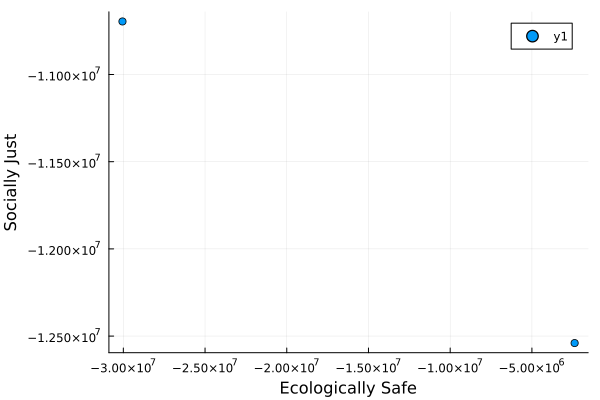

In [15]:
x_axis = [EO1, EO2]
y_axis = [SS2, SS1]

# plot(x_axis, y_axis)
# plot!(x_axis, y_axis, seriestype=:scatter)
scatter(x_axis, y_axis)

# title!("Over the whole supply chain (ϵ-constraint)")
xlabel!("Ecologically Safe")
ylabel!("Socially Just")

----

### Pareto Front Plot

In [16]:
function cal_intm(EO_m)
    model = Model(Gurobi.Optimizer)
    set_silent(model)
    @variable(model, x[1:ncty, 1:nproc] >= 0)           
    @variable(model, y[1:ncty, 1:ncty, 1:nproc] >= 0)
    
    
    cstr_cap = [@constraint(model, x[i,k] <= capacity[!, 2:end][i,k]) for k in 1:nproc for i in 1:ncty]
    cstr_lca = [@constraint(model, sum(x[i,k] for i in 1:ncty) == input_amount[k]) for k in 1:nproc]
    cstr_op = [@constraint(model, sum(y[i,j,k] for j in 1:ncty) == x[i,k]) for k in 1:nproc for i in 1:ncty]
    cstr_cth = [@constraint(model, sum(y[i,j,k] for i in 1:ncty) == x[j,5]*scaler[k]) for k in cathode for j in 1:ncty]
    cstr_cell = [@constraint(model, sum(y[i,j,k] for i in 1:ncty) == x[j,11]*scaler[k]) for k in cell for j in 1:ncty]
    cstr_noncell = [@constraint(model, sum(y[i,j,k] for i in 1:ncty) == x[j,14]*scaler[k]) for k in noncell for j in 1:ncty]
    cstr_battery = [@constraint(model, sum(y[i,j,k] for i in 1:ncty) == x[j,15]*scaler[k]) for k in battery for j in 1:ncty]
    @constraint(model, sum(y[i,mkt_loc,mkt_proc] for i in 1:ncty) == cell_demand)
    for j in 1:ncty-1
        @constraint(model, sum(y[i,j,mkt_proc] for i in 1:ncty) == 0)
    end
    
    
    # obj func calculation
    proD = (x .* Matrix(regional_EF[:,2:end])) * ones(nproc,1)  # ncty*1 matrix
    pro_sink = zeros(ncty, nproc)
    for k in 1:nproc
        for i in 1:ncty
            pro_sink[i,k] = regional_EF[i, k+1] * (sink_c[i]/emission_c[i] + es_ratio)
        end
    end
    proS = (x.*pro_sink)*ones(nproc,1)  # ncty*1 matrix

    transS = Vector{AffExpr}(undef, ncty)
    transD = Vector{AffExpr}(undef, ncty)
    for j in 1:ncty
        arc_emi = 0
        arc_seq = 0
        for i in 1:ncty
            amount = sum(y[i,j,k] for k in 1:nproc)
            arc_emi += amount * distance[!, 2:end][i,j] * EF_trans
            arc_seq += arc_emi * (sink_c[j]/emission_c[j] + es_ratio)
        end
        transD[j] = arc_emi  # ncty*1 matrix
        transS[j] = arc_seq  # ncty*1 matrix
    end
    
    Allo_soc = proD ./ emission_c .* Dsoc
    SS = Allo_soc - (proD + transD)
    
    EO = sum(proD - proS + transD - transS)
    @constraint(model, EO==EO_m)
    
#     if EO_m > 0
#         @constraint(model, sum(proD-proS+transD-transS) >= (0.99*EO_m))
#         @constraint(model, sum(proD-proS+transD-transS) <= (1.01*EO_m))
#     else
#         @constraint(model, sum(proD-proS+transD-transS) >= (1.01*EO_m))
#         @constraint(model, sum(proD-proS+transD-transS) <= (0.99*EO_m)) 
#     end
    
    @objective(model, Min, sum(SS));

    JuMP.optimize!(model)
    opt_obj = JuMP.objective_value(model)
    
    return opt_obj
end
    

cal_intm (generic function with 1 method)

In [17]:
function ep_constraint(N)
    
    ep = (EO2 - EO1) / N
    ls_ss = []
    ls_eo = []
    for i in 0:N
        EO_m = EO1 + i*ep
        obj_ss = cal_intm(EO_m)
        push!(ls_ss, obj_ss)
        push!(ls_eo, EO_m)
    end
    
    return ls_ss, ls_eo
end
        

ep_constraint (generic function with 1 method)

In [18]:
ls_ss, ls_eo = ep_constraint(4)

Academic license - for non-commercial use only - expires 2024-12-26
Academic license - for non-commercial use only - expires 2024-12-26
Academic license - for non-commercial use only - expires 2024-12-26
Academic license - for non-commercial use only - expires 2024-12-26
Academic license - for non-commercial use only - expires 2024-12-26


(Any[-1.0696057136646627e7, -1.2051210804550985e7, -1.2360650583082313e7, -1.2490250627347277e7, -1.254009123111362e7], Any[-3.0052577077099532e7, -2.313601903706219e7, -1.6219460997024849e7, -9.302902956987508e6, -2.386344916950166e6])

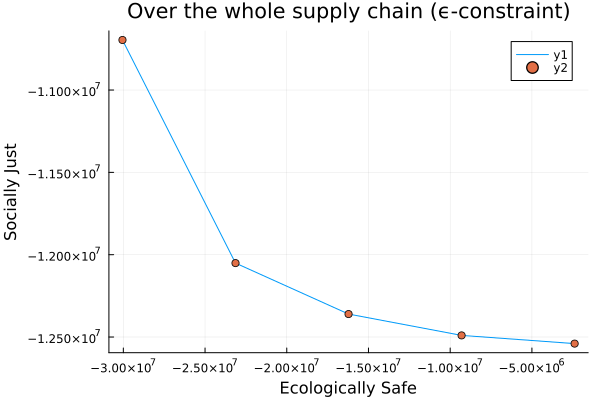

In [19]:
x_axis = ls_eo
y_axis = ls_ss

plot(x_axis, y_axis)
plot!(x_axis, y_axis, seriestype=:scatter)
# scatter(x_axis, y_axis)

title!("Over the whole supply chain (ϵ-constraint)")
xlabel!("Ecologically Safe")
ylabel!("Socially Just")